# Part 3. Force-based column adjusting

The next step is column adjusting. We want to minimize edge intersections. We try to use force-based approach. For every node, we need to calculate an imaginary "force" that's applied to it from connected nodes. This force may pull given node to the left or to the right.

An important questions is whether should we consider vertical distance (a difference in layers) or not. The following possible models come into my mind:

1. "Neutral": we do not consider vertical distance, just horisontal distance solely.
2. "Gravitational": the more vertical distance is, the **less** a horisontal distance from this node contributes to the final result.
3. "Rubber": the more vertical distance is, the **more** a horisontal distance from this node contributes to the final result.

In [15]:
# Rendering defaults
WIDTH = 3

In [16]:
import matplotlib.pyplot as plt
from typing import Any, Dict, List, Set, Union, Optional
from dataclasses import dataclass, field, replace
from enum import IntEnum
from random import randint

In [17]:
# One of two supported edge types
class EdgeType(IntEnum):
    BLOCKER = 1
    PARENT = 2

# Edge between two goals (wow, it doesn't use GoalId, right?)
@dataclass(frozen=True)
class Edge:
    source: int
    target: int
    type: EdgeType

# For leegacy reasons, goal id may be either integer (real or pseudo goal) or string (pseudo goal only)
GoalId = Union[str, int]

# Single row of "render result" (well, actually, it's a single goal)
@dataclass(frozen=True)
class RenderRow:
    """Strongly typed rendered representation of a single goal."""

    goal_id: GoalId
    raw_id: int
    name: str
    is_open: bool
    is_switchable: bool
    edges: list[tuple[GoalId, EdgeType]]
    attrs: dict[str, str] = field(default_factory=lambda: {})

# A whole result of "rendering" (also suitable for result returned by a single request to goal tree)
@dataclass
class RenderResult:
    rows: list[RenderRow]
    edge_opts: dict[str, tuple[int, int, int]]
    select: tuple[GoalId, GoalId]
    node_opts: dict[GoalId, Any]
    roots: set[GoalId]
    index: dict[GoalId, int]

    def __init__(
        self,
        rows: list[RenderRow],
        edge_opts: Optional[dict[str, tuple[int, int, int]]] = None,
        select: Optional[tuple[GoalId, GoalId]] = None,
        node_opts: Optional[dict[GoalId, Any]] = None,
        roots: Optional[set[GoalId]] = None,
    ):
        self.rows = rows
        self.edge_opts = edge_opts or {}
        self.select = select or (0, 0)
        self.node_opts = node_opts or {}
        self.roots = roots or set()
        self.index = {row.goal_id: i for i, row in enumerate(rows)}

    def goals(self):
        return [
            (goal_id, attrs)
            for goal_id, attrs in self.node_opts.items()
            if isinstance(goal_id, int)
        ]

    def by_id(self, goal_id: GoalId) -> RenderRow:
        assert goal_id in self.index
        return self.rows[self.index[goal_id]]


In [18]:
# Some example graph
edges = {
    1: [8, 10, 12, 13],
    2: [5],
    3: [6],
    4: [],
    5: [],
    6: [],
    7: [],
    8: [],
    9: [],
    10: [11],
    11: [3],
    12: [2, 4, 14],
    13: [7, 9],
    14: [],
}

sample_result = RenderResult(
    [
        RenderRow(k, k, f"Goal {k}", True, not es,
                  [(e, EdgeType.PARENT) for e in es], {})
        for k, es in edges.items()
    ],
    node_opts={k: {} for k in edges},
    select=(1, 1),
    roots={1},
)

In [19]:
def draw(rr: RenderResult, min_row: int = 0) -> None:
    xpos: Dict[int, int] = {}
    ypos: Dict[int, int] = {}
    for goal_id, attrs in rr.goals():
        row, col = attrs.get("row", None), attrs.get("col", None)
        # print(goal_id, row, col)
        xpos[goal_id] = col if col is not None else randint(0, 10)
        ypos[goal_id] = row if row is not None else randint(min_row, 10) 
    # print(xpos)
    # print(ypos)
    for row in rr.rows:
        row_id = row.goal_id
        for edge in row.edges:
            e = edge[0]
            plt.plot([xpos[row_id], xpos[e]], [ypos[row_id], ypos[e]], 'ro-')
        plt.text(xpos[row_id] + 0.1, ypos[row_id], row.name)
    tops = [row.goal_id for row in rr.rows if row.is_switchable]
    plt.plot([xpos[t] for t in tops], [ypos[t] for t in tops], 'bo')
    plt.draw()

In [23]:
def add_if_not(m: Dict, m1: Dict) -> Dict:
    nm = dict(m)
    for k, v in m1.items():
        if nm.get(k, None) is None:
            nm[k] = v
    return nm

def tube(rr: RenderResult, roots: List[int], layers: List[List[int]]):
    new_layer: List[int] = roots[:WIDTH]
    new_roots: List[int] = roots[len(new_layer):] + [e[0] for gid in new_layer for e in rr.by_id(gid).edges]
    new_opts: Dict[int, Dict] = {
        goal_id: add_if_not(opts, {
            "row": len(layers) if goal_id in new_layer else None,
            "col": new_layer.index(goal_id) if goal_id in new_layer else None
        })
        for goal_id, opts in rr.node_opts.items()
    }
    
    return RenderResult(rr.rows, node_opts=new_opts, select=rr.select, roots=rr.roots), new_roots, layers + [new_layer]

def split_to_layers(rr: RenderResult) -> RenderResult:
    roots = list(rr.roots)
    layers = []
    while roots:
        rr, roots, layers = tube(rr, roots, layers)
    return rr

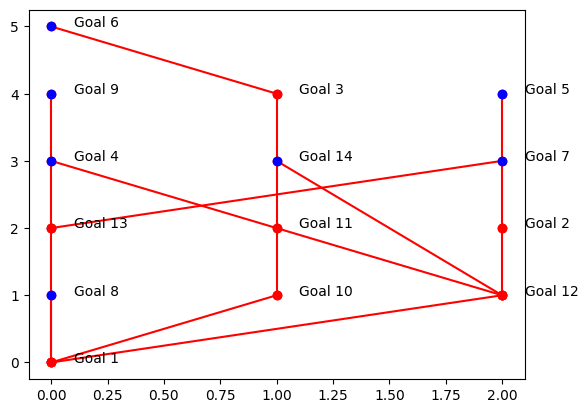

In [22]:
sample_with_layers = split_to_layers(sample_result)
draw(sample_with_layers)

Let's take a look to the current differences of our graph.

In [24]:
def avg(vals):
    return sum(vals) / len(vals)

def shift_neutral(ds):
    return avg([d[1] for d in ds])

def calc_shift(rr: RenderResult, shift_fn):
    connected: Dict[int, Set[int]] = {row.goal_id: set() for row in rr.rows}
    for row in rr.rows:
        for e in row.edges:
            connected[e[0]].add(row.goal_id)
            connected[row.goal_id].add(e[0])

    result = {}
    for row in rr.rows:
        goal_id = row.goal_id
        opts = rr.node_opts[goal_id]
        row_, col_ = opts['row'], opts['col']
        deltas = [
            (rr.node_opts[c]['row'] - row_,
             rr.node_opts[c]['col'] - col_)
            for c in connected[goal_id]
        ]
        result[goal_id] = shift_fn(deltas)
    return result

In [25]:
calc_shift(sample_with_layers, shift_neutral)

{1: 0.75,
 2: 0.0,
 3: -0.5,
 4: 2.0,
 5: 0.0,
 6: 1.0,
 7: -2.0,
 8: 0.0,
 9: 0.0,
 10: -0.5,
 11: 0.0,
 12: -1.25,
 13: 0.6666666666666666,
 14: 1.0}

Let's proceed with a "neutral shift" for now. Having shifts calculated, we apply a _half_ of horisontal shift for each of nodes. Why just a half? Because every shift is a result of _mutual_ interaction between nodes. If we move two nodes for the full length of shift towards each other, they could simply swap their columns, and new distance between them would become non-null again.

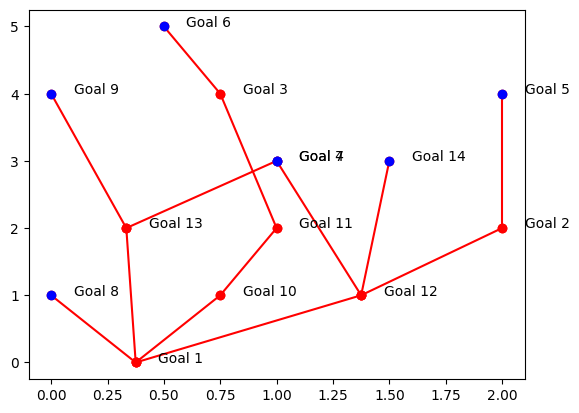

In [27]:
def adjust_horisontal(rr: RenderResult, mult):
    deltas = calc_shift(rr, shift_neutral)
    new_opts = {
        goal_id: opts | {"col": opts["col"] + (mult * deltas[goal_id])}
        for goal_id, opts in rr.node_opts.items()
    }
    return RenderResult(
        rr.rows,
        node_opts=new_opts,
        select=rr.select,
        roots=rr.roots
    )

draw(adjust_horisontal(sample_with_layers, 0.5))

Well, a very little was changed. Only "Goal 7" and "Goal 14" have swapped their positions. Looks like we should try to apply shift more eagerly.

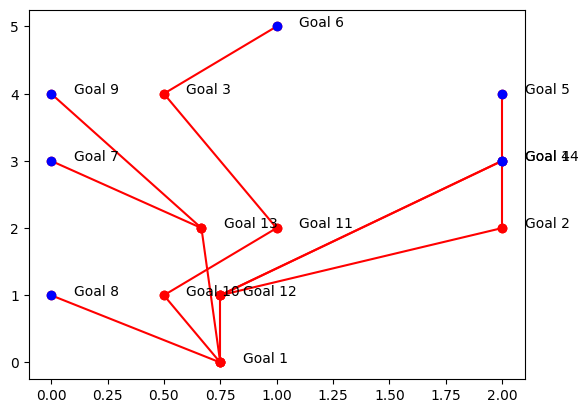

In [28]:
draw(adjust_horisontal(sample_with_layers, 1.0))

Not a big difference. But let's try to run it one or more times recursively.

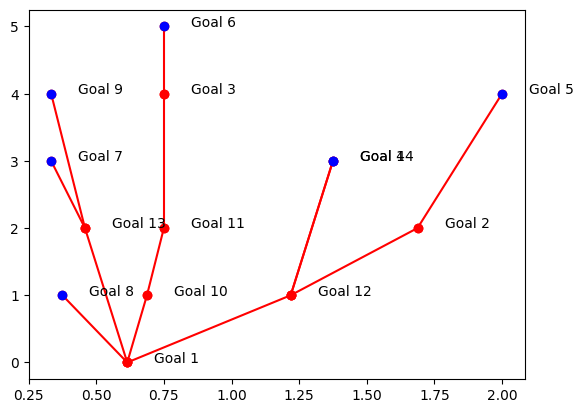

In [29]:
sample_adj1_1 = adjust_horisontal(sample_with_layers, 1.0)
sample_adj1_2 = adjust_horisontal(sample_adj1_1, 0.5)
draw(sample_adj1_2)

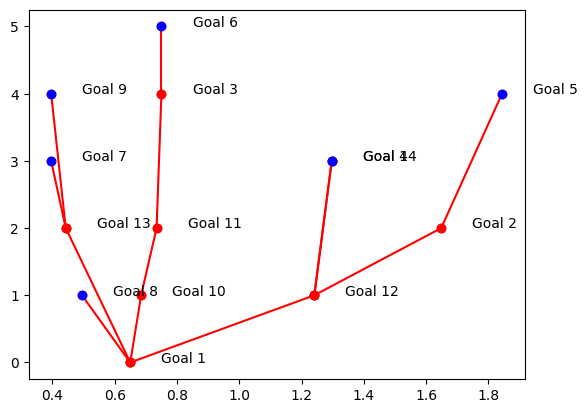

In [30]:
sample_adj1_3 = adjust_horisontal(sample_adj1_2, 0.5)
draw(sample_adj1_3)

That looks much better! It even resemles an original graph, except with a "normalized" number of nodes on each level. Also, for such a simple graph we only need to apply 2 adjustment steps, with decreasing coefficients 1.0 and 0.5.

Now, we need to return back to integer-valued columns. How could we do it? We'll try to sort nodes in each row by their new "col" value and then use its index as a new col.

In [31]:
def normalize_cols(rr: RenderResult) -> RenderResult:
    order0 = {}
    for goal_id, opts in rr.node_opts.items():
        row, col = opts["row"], opts["col"]
        if row not in order0:
            order0[row] = []
        order0[row].append((col, goal_id))
    # print("order0: ", order0)
    order1 = {}
    for layer, tuples in order0.items():
        non_empty = list(round(t[0]) for t in tuples)
        need_drop = len(tuples) - len(set(non_empty))
        empty = {x for x in range(WIDTH)}.difference(non_empty)
        for i in range(need_drop):
            empty.pop()
        # print(f"{layer}: non-empty {non_empty}, empty {empty}, dropped {need_drop}")
        order1[layer] = tuples + [(e, -10) for e in empty]
    # print("order1: ", order1)
    order2 = {k: sorted(v) for k, v in order1.items()}
    # print("order2: ", order2)
    indexed0 = {k: [t[1] for t in v] for k, v in order2.items()}
    # print("indexed0: ", indexed0)
    indexed1 = {}
    for layer in indexed0.values():
        for i, goal_id in enumerate(layer):
            if goal_id > 0:
                indexed1[goal_id] = i
    # print("indexed1: ", indexed1)
    new_opts = {
        goal_id: opts | {"col": indexed1[goal_id]}
        for goal_id, opts in rr.node_opts.items()
    }
    # print(new_opts)
    return RenderResult(
        rr.rows,
        node_opts=new_opts,
        select=rr.select,
        roots=rr.roots
    )

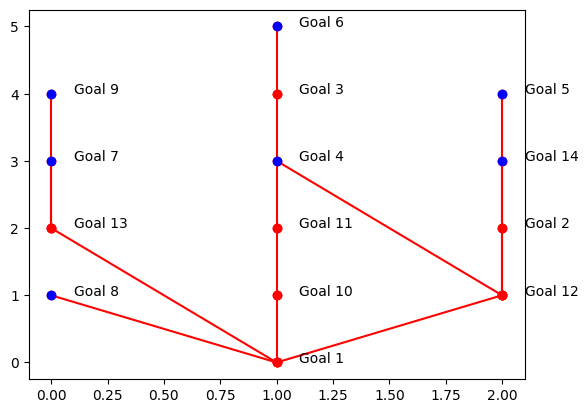

In [32]:
draw(normalize_cols(sample_adj1_2))

**WOOT!**

Now it's much better than the unadjusted version!

An important distinction to the _current_ rendering algorithms within SiebenApp is lack of "fake goals" (actually representing intersection of long edges and horisontal layers). Probably, this change is even crucial. Without fake goals on this stage, we gain two important advantages:

1. A total number of goals to work with is reduced (in other words, we need to perform less computations).
2. An overall "force effect" doesn't depend on the number of levels between two connected nodes. It affects both nodes immediately, and that's great.

We would need to add fake goals at the next stage, when we would draw edges bypassing nodes. But tree adjustment works better without them.